In [1]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from model.unet_single_inference import UNetSingleInference

(2048, 2880, 3)


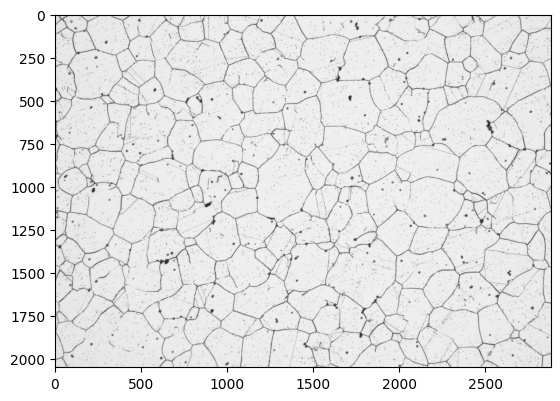

In [2]:
# Input Image: 2880*2048
img = cv2.imread('ex_A.jpg')
save_img = Image.fromarray(img)
save_img.save('./after/1-original.jpg')
print(img.shape)
plt.imshow(img)

(2048, 2880)


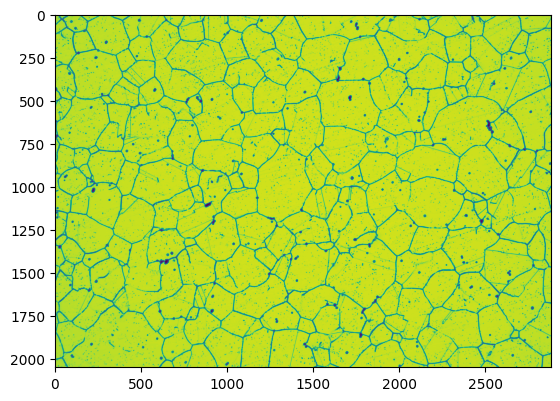

In [3]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
save_img = Image.fromarray(img)
save_img.save('./after/2-binary.jpg')
print(img.shape)
plt.imshow(img)

(1024, 1440)


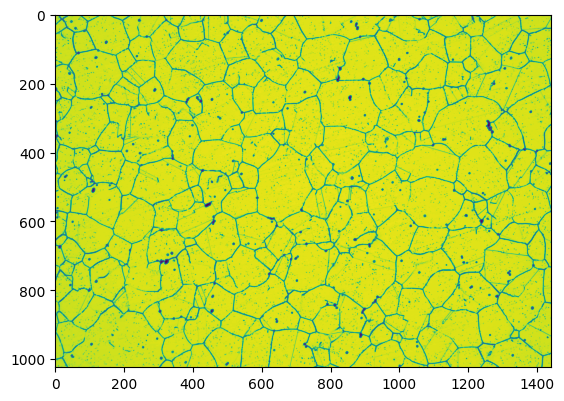

In [4]:
# resize 1440*1024
pil_image = Image.fromarray(img)
resized_pil_image = pil_image.resize((1440, 1024), Image.LANCZOS)
re_img = np.array(resized_pil_image)
save_img = Image.fromarray(re_img)
save_img.save('./after/3-resize.jpg')
print(re_img.shape)
plt.imshow(re_img)

(512, 512)


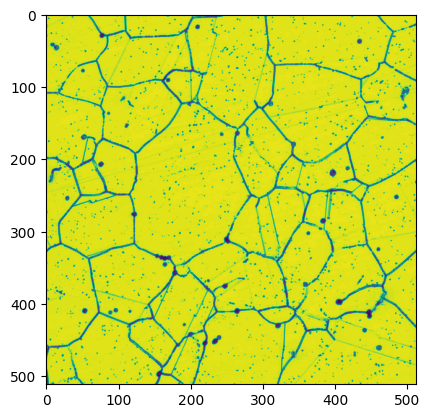

In [5]:
# Center Crop
width, height = resized_pil_image.size
if width < 1440 or height < 1024:
    resized_pil_image = resized_pil_image.resize((1440, 1024), Image.LANCZOS)
    width, height = resized_pil_image.size

new_size = 512
left = int((width - new_size) / 2)
top = int((height - new_size) / 2)
right = int(left + new_size)
bottom = int(top + new_size)

cropped = resized_pil_image.crop((left, top, right, bottom))
cropped = np.asarray(cropped)
save_img = Image.fromarray(cropped)
save_img.save('./after/4-center_crop.jpg')
print(cropped.shape)
plt.imshow(cropped)

(512, 512)


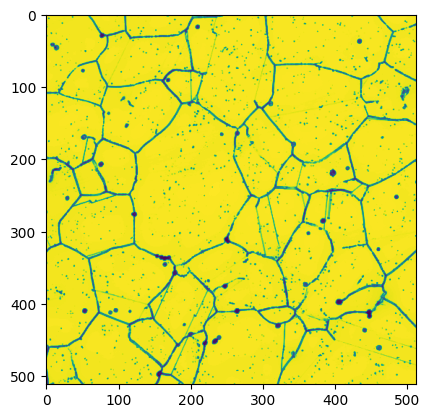

In [6]:
# bilateralFilter
bifil_img = cv2.bilateralFilter(cropped,-1,10,10)
save_img = Image.fromarray(bifil_img)
save_img.save('./after/5-filter.jpg')
print(bifil_img.shape)
plt.imshow(bifil_img)

(512, 512)


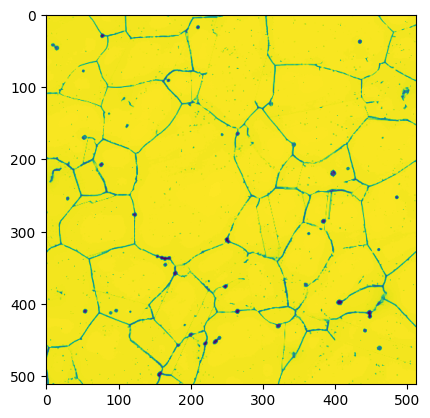

In [7]:
# dilation
kernel_size = (2,2)
kernel = np.ones(kernel_size, np.uint)
di_img = cv2.dilate(bifil_img, kernel, 1)
save_img = Image.fromarray(di_img)
save_img.save('./after/6-dilation.jpg')
print(di_img.shape)
plt.imshow(di_img)

c:\Users\song\Desktop\my_seah\model\unet_single_inference.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path, map_location=torch.device(

<class 'numpy.ndarray'>
(512, 512)


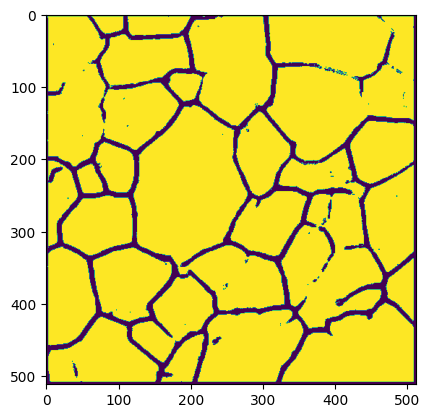

In [8]:
# model - UNet
ckpt_dir = './ckpt/model_epoch50.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if_manager = UNetSingleInference(model_path=ckpt_dir, device=device)
output = if_manager.inference(di_img)
output_img = (output[0, :, :, 0] * 255).astype(np.uint8)
save_img = Image.fromarray(output_img)
save_img.save('./after/7-seg_output.jpg')
print(type(output_img))
print(output_img.shape)
plt.imshow(output_img)

In [23]:
output.shape, output_img.shape

((1, 512, 512, 1), (512, 512))

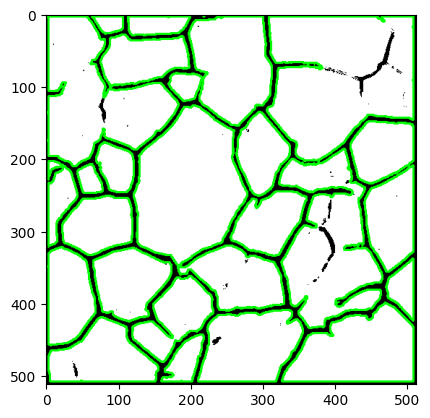

In [28]:
# Contour Detection
# No need (squeze, binary )
draw_img = output_img.copy()
contours, _ = cv2.findContours(draw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
draw_img = cv2.cvtColor(draw_img, cv2.COLOR_GRAY2BGR)  
cv2.drawContours(draw_img, contours, -1, (0, 255, 0), 2)
save_img = Image.fromarray(draw_img)
save_img.save('./after/8-contour.jpg')
plt.imshow(draw_img)

Number of contours detected: 34


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

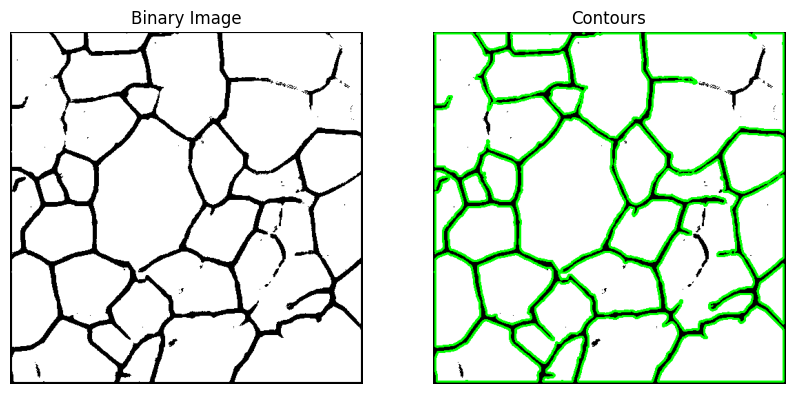

In [29]:
num_contours = len(contours)
print("Number of contours detected:", num_contours)

plt.figure(figsize=(10, 5))

# 이진화된 이미지
plt.subplot(1, 2, 1)
plt.title('Binary Image')
plt.imshow(output_img, cmap='gray')
plt.axis('off')

# 컨투어가 그려진 이미지
plt.subplot(1, 2, 2)
plt.title('Contours')
plt.imshow(draw_img)
plt.axis('off')

In [11]:
img_path = './after/iimg.jpg'

In [12]:
# 이미지 메타데이터 구성
image_id = 1
image_filename = os.path.basename(img_path)
height, width = output_img.shape[:2]

images = [{
    "id": image_id,
    "file_name": image_filename,
    "height": height,
    "width": width
}]

In [13]:
# 범주 정보 구성 (여기서는 한 가지 범주만 정의)
category_id = 1
categories = [{
    "id": category_id,
    "name": "object",
    "supercategory": "none"
}]

In [14]:
# 주석 정보 구성
annotations = []
annotation_id = 1

for contour in contours:
    segmentation = contour.flatten().tolist()
    x, y, w, h = cv2.boundingRect(contour)
    bbox = [x, y, w, h]
    area = cv2.contourArea(contour)
    
    annotation = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_id,
        "segmentation": [segmentation],
        "area": area,
        "bbox": bbox,
        "iscrowd": 0
    }
    annotations.append(annotation)
    annotation_id += 1

In [15]:
# COCO 형식 데이터 구성
coco_format = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

In [16]:
json_path = img_path.replace('jpg', 'json')
with open(json_path, 'w') as json_file:
    json.dump(coco_format, json_file, indent=4)

In [30]:
# di_img + contour = JSON
img_path = './after/test_1.jpg'
img_B_filename = os.path.basename(img_path)

pro_di_img = (di_img[ :, :] * 255).astype(np.uint8)
save_img = Image.fromarray(pro_di_img)
save_img.save(img_path)

image_id = 1
category_id = 1

images = [{
    "id": image_id,
    "file_name": img_B_filename,
    "height": height,
    "width": width
}]

categories = [{
    "id": category_id,
    "name": "object",
    "supercategory": "none"
}]

annotations = []
annotation_id = 1

for contour in contours:
    seg_ = contour.flatten().tolist()
    x, y, w, h = cv2.boundingRect(contour)
    bbox = [x, y, w, h]
    area = cv2.contourArea(contour)
    annotation = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_id,
        "segmentation": [seg_],
        "area": area,
        "bbox": bbox,
        "iscrowd": 0
    }
    annotations.append(annotation)
    annotation_id += 1

coco_format = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

json_path = img_path.replace('jpg', 'json')
with open(json_path, 'w') as json_file:
    json.dump(coco_format, json_file, indent=4)

In [21]:
di_img.shape

(512, 512)

In [24]:
print(type(di_img))
pro_di_img = (di_img[ :, :] * 255).astype(np.uint8)
print(type(pro_di_img))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [25]:
di_img[0][0], pro_di_img[0][0]

(np.uint8(238), np.uint8(18))

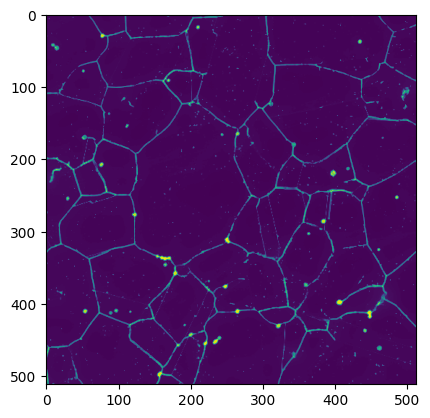

In [26]:
plt.imshow(pro_di_img)

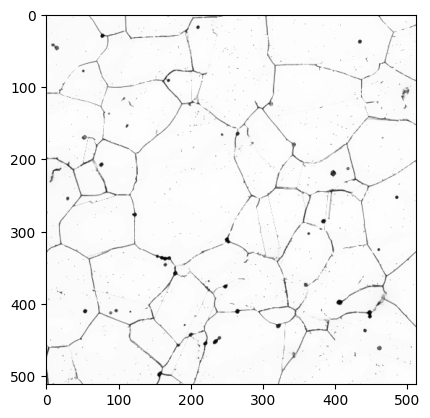

In [35]:
inverted_img = cv2.bitwise_not(pro_di_img)
plt.imshow(inverted_img, cmap='gray')

In [36]:
img_path = './after/test_1.jpg'
img_B_filename = os.path.basename(img_path)

pro_di_img = (di_img[ :, :] * 255).astype(np.uint8)
inverted_img = cv2.bitwise_not(pro_di_img)
save_img = Image.fromarray(inverted_img)
save_img.save(img_path)